In [1]:
import os
import torch
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")

### Import the Data

In [2]:
# Load the training and validation datasets
train_df = pd.read_csv('./Data/train.csv', sep='\t')
val_df = pd.read_csv('./Data/dev.csv', sep='\t')
test_df = pd.read_csv('./Data/sample_demo.csv', sep='\t')

print("Training data shape: ", train_df.shape)
print("Validation data shape: ", val_df.shape)
print("Test data shape: ", test_df.shape)
train_df.head()

Training data shape:  (5711, 3)
Validation data shape:  (1470, 3)
Test data shape:  (6, 4)


,score,sentence1,sentence2
0,5.00,A plane is taking off.,An air plane is taking off.
1,3.80,A man is playing a large flute.,A man is playing a flute.
2,3.80,A man is spreading shreded cheese on a pizza.,A man is spreading shredded cheese on an uncoo...
3,2.60,Three men are playing chess.,Two men are playing chess.
4,4.25,A man is playing the cello.,A man seated is playing the cello.


In [3]:
train_df = train_df.dropna()
val_df = val_df.dropna()
test_df = test_df.dropna()
print("Training data shape after dropping NaNs: ", train_df.shape)
print("Validation data shape after dropping NaNs: ", val_df.shape)
print("Test data shape after dropping NaNs: ", test_df.shape)

Training data shape after dropping NaNs:  (5708, 3)
Validation data shape after dropping NaNs:  (1468, 3)
Test data shape after dropping NaNs:  (6, 4)


### Import the required libraries

In [5]:
import torch
import numpy as np
from transformers import BertTokenizer, BertModel, BertConfig, AdamW, get_linear_schedule_with_warmup
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import mean_squared_error
from scipy.stats import pearsonr
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import transformers
transformers.logging.set_verbosity_error()

### Create Dataset and Data Loader

In [6]:
class TextSimilarityDataset(Dataset):
    def __init__(self, df, tokenizer, max_length=128):
        self.df = df
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        sentence1 = self.df.iloc[idx]['sentence1']
        sentence2 = self.df.iloc[idx]['sentence2']
        score = self.df.iloc[idx]['score']

        inputs = self.tokenizer.encode_plus(
            sentence1,
            sentence2,
            add_special_tokens=True,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )

        return {
            'input_ids': inputs['input_ids'].squeeze(0),
            'attention_mask': inputs['attention_mask'].squeeze(0),
            'labels': torch.tensor(score, dtype=torch.float)
        }

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = BertModel.from_pretrained('bert-base-uncased')

In [50]:
train_dataset = TextSimilarityDataset(train_df, tokenizer, max_length=128)
val_dataset = TextSimilarityDataset(val_df, tokenizer, max_length=128)
test_dataset = TextSimilarityDataset(test_df, tokenizer, max_length=128)
print(len(train_dataset), len(val_dataset), len(test_dataset))

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=2, shuffle=False)
print(len(train_loader), len(val_loader), len(test_loader))

5708 1468 6
90 23 3


In [83]:
for data in train_loader:
    print(train_dataset.tokenizer.decode(data['input_ids'][0]))
    print(train_dataset[0]['input_ids'].shape)
    print(data['input_ids'].shape)
    print(data['attention_mask'].shape)
    print(data['labels'].shape)
    print(data['input_ids'][:, 0])
    # print(data['attention_mask'][0])
    break

[CLS] a group of people sitting at a restaurant table. [SEP] a group of people sitting around a table with food on it. [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]
torch.Size([128])
torch.Size([64, 128])
torch.Size([64, 128])
torch.Size([64])
tensor([101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101,
        101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101,
        101, 101, 101, 101, 

### Create BERT Model

In [31]:
import torch
import torch.nn as nn

class BertModel(nn.Module):
    def __init__(self, bert_model):
        super(BertModel, self).__init__()
        self.bert = bert_model
        self.linear = nn.Linear(self.bert.config.hidden_size, 1)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs['pooler_output']
        logits = self.linear(pooled_output)
        return logits

### Training and Validation

In [68]:
def train(model, dataloader, optimizer, criterion, device):
    model.train()
    total_loss = 0
    model = model.to(device)
    for i, (batch) in enumerate(dataloader):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask)
        loss = criterion(outputs.flatten(), labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        if i % 20 == 0:
            print(f'Batch {i}, Loss: {loss.item()}')
    return total_loss / len(dataloader)


def evaluate(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0
    model = model.to(device)
    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            outputs = model(input_ids, attention_mask)
            loss = criterion(outputs.flatten(), labels)
            total_loss += loss.item()
    return total_loss / len(dataloader)

In [35]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
num_epochs = 10
learning_rate = 2e-5

model = BertModel(bert_model).to(device)
optimizer = AdamW(model.parameters(), lr=learning_rate)
criterion = nn.MSELoss()

In [36]:
training_loss, validation_loss = [], []
for epoch in range(num_epochs):
    train_loss = train(model, train_loader, optimizer, criterion, device)
    val_loss, val_preds = evaluate(model, val_loader, criterion, device)
    training_loss.append(train_loss)
    validation_loss.append(val_loss)
    print(f'--> Epoch: {epoch + 1}, Training Loss: {train_loss}, Validation Loss: {val_loss}')

Batch 0, Loss: 7.290775299072266
Batch 20, Loss: 2.0682568550109863
Batch 40, Loss: 1.7635372877120972
Batch 60, Loss: 1.253429889678955
Batch 80, Loss: 0.5618610382080078
--> Epoch: 1, Training Loss: 1.816809159848425, Validation Loss: 0.721024549525717
Batch 0, Loss: 0.7144342660903931
Batch 20, Loss: 0.6915478110313416
Batch 40, Loss: 0.4368951916694641
Batch 60, Loss: 0.5863120555877686
Batch 80, Loss: 1.0564459562301636
--> Epoch: 2, Training Loss: 0.5991810616519716, Validation Loss: 0.6133220299430515
Batch 0, Loss: 0.42003369331359863
Batch 20, Loss: 0.3871145248413086
Batch 40, Loss: 0.5550764799118042
Batch 60, Loss: 0.47885996103286743
Batch 80, Loss: 0.4012841582298279
--> Epoch: 3, Training Loss: 0.4156143089135488, Validation Loss: 0.5922336759774581
Batch 0, Loss: 0.41178247332572937
Batch 20, Loss: 0.2653651535511017
Batch 40, Loss: 0.26930472254753113
Batch 60, Loss: 0.2791517972946167
Batch 80, Loss: 0.28424763679504395
--> Epoch: 4, Training Loss: 0.3026408894194497,

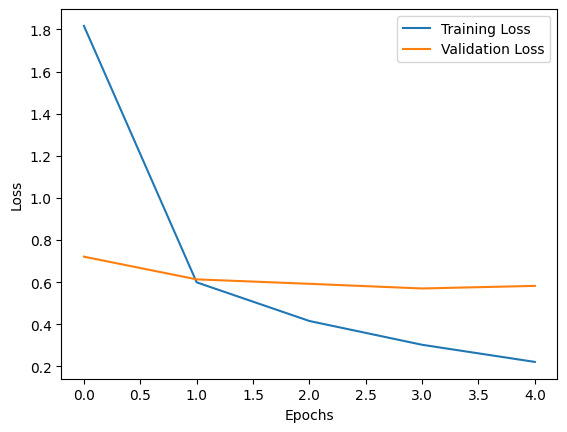

In [37]:
plt.plot(training_loss, label='Training Loss')
plt.plot(validation_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [69]:
val_loss = evaluate(model, val_loader, criterion, device)
print(f'Validation Loss: {val_loss}')
test_loss = evaluate(model, test_loader, criterion, device)
print(f'Test Loss: {test_loss}')

Validation Loss: 0.5823692187019016
Test Loss: 0.06607421780548368


### Saving and Loading for future

In [70]:
model = model.to('cpu')
torch.save(model.state_dict(), 'q1a_bert_model.pth')

In [71]:
loaded_model = BertModel(bert_model)
loaded_model.load_state_dict(torch.load('q1a_bert_model.pth'))
loaded_model = loaded_model.to(device)

val_loss = evaluate(loaded_model, val_loader, criterion, device)
print(f'Validation Loss: {val_loss}')
test_loss = evaluate(loaded_model, test_loader, criterion, device)
print(f'Test Loss: {test_loss}')

Validation Loss: 0.5823692187019016
Test Loss: 0.06607421780548368


### Calculate Pearson Coefficients

In [75]:
def get_predictions(model, dataloader, device):
    model.eval()
    actual_scores = []
    predicted_scores = []
    model = model.to(device)
    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            outputs = model(input_ids, attention_mask)
            actual_scores.extend(batch['labels'].numpy().tolist())
            predicted_scores.extend(outputs.flatten().tolist())
    return actual_scores, predicted_scores

In [76]:
val_actual, val_preds = get_predictions(loaded_model, val_loader, device)
test_actual, test_preds = get_predictions(loaded_model, test_loader, device)

In [87]:
from scipy.stats import pearsonr

val_pearson, _ = pearsonr(val_preds, val_actual)
test_pearson, _ = pearsonr(test_preds, test_actual)

print(f'Validation Pearson Correlation: {val_pearson}')
print(f'Test Pearson Correlation: {test_pearson}')

Validation Pearson Correlation: 0.8676728865750375
Test Pearson Correlation: 0.9784852902947985
